##Install Required Libraries

In [1]:
!pip install -q \
    transformers==4.40.0 \
    peft==0.10.0 \
    accelerate \
    datasets==2.19.1 \
    scikit-learn==1.4.2 \
    sentence-transformers \
    umap-learn \
    gcsfs \
    PyPDF2 \
    pymupdf \
    faiss-cpu \
    langchain \
    langchain-openai \
    gradio

!pip install numpy==1.26.4 --force-reinstall --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 230.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
cuml-cu12 25.6.0 requires scikit-learn>=1.5, but you have scikit-learn 1.4.2 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_

##Necessary Imports

In [1]:
import os
import json
import re
import pandas as pd
import numpy as np


#Visualization
import matplotlib.pyplot as plt
import seaborn as sns


#Machine Learning / Transformers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)

#Datasets
from datasets import Dataset
from google.colab import files

##Upload and Load Dataset

In [2]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]

with open(filename, "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()

Saving LegalMind.json to LegalMind.json


,case_id,summary,offence_sections,verdict,case_type,petitioner_argument,respondent_argument
0,Cr.R No. 34-P/2025,"The petitioners, afghan citizens, challenged t...",[Section 5(2) of the Prevention of Corruption ...,dismissed,Criminal Revision,The petitioners are afghan citizens and not li...,The petitioners are charged with multiple offe...
1,Cr.M (B.A) No.87-M/2025,The petitioner sought post-arrest bail under S...,"[Section 302 PPC, Section 311 PPC, Section 120...",dismissed,Bail Application,Statutory delay in trial exceeding prescribed ...,Accused falls under fourth proviso exception a...
2,Cr.Appeal No. 195-A/2024,The appellants challenged their conviction und...,[Section 17(4) of the Offences Against Propert...,transferred,Criminal Appeal,Appeals are maintainable in High Court as conv...,Appeals must be filed in Federal Shariat Court...
3,Cr.A No. 273-P/2024,The appellant challenged his conviction under ...,[Section 9(d) of the Khyber Pakhtunkhwa Contro...,Allowed,Criminal Appeal,Sentences are too harsh and should be reduced;...,Sentences are commensurate with the gravity of...
4,Cr.A.No.286-M/2023 with Murder Ref: No.05-M/2023,The appellant challenged his conviction under ...,"[Section 302 PPC (Murder), Section 311 PPC (Pu...",Acquitted,Criminal Appeal with Murder Reference,Prosecution failed to prove guilt due to unrel...,Appellant was convicted based on eyewitness ac...


##Cleaning

In [3]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[\n\r\t]", " ", text)
    text = re.sub(r"[\"']", "", text)
    text = re.sub(r"[^a-z0-9 ,.\[\]()/\-:]", "", text)
    text = re.sub(r"\.{2,}", ".", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[,/]+", ",", text)
    text = re.sub(r"(,\s*,)+", ",", text)
    text = re.sub(r"(,\s*$)|(^\s*,)", "", text)
    text = re.sub(r"\b(p\s*,\s*p\s*,\s*c)\b", "ppc", text)
    return text.strip()

def format_case(row):
    summary = clean_text(row["summary"])
    petitioner = clean_text(row["petitioner_argument"])
    respondent = clean_text(row["respondent_argument"])
    case_type = clean_text(row.get("case_type", ""))
    sections = clean_text(", ".join(row.get("offence_sections", [])))
    return f"[SUMMARY] {summary} [PETITIONER] {petitioner} [RESPONDENT] {respondent} [CASE TYPE] {case_type} [SECTIONS] {sections}"


##Clean Verdicts & Label Encoding

In [4]:
#Clean verdicts
df["verdict"] = df["verdict"].apply(clean_text)

#Encode labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["verdict"])
label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
df["label_name"] = df["label"].map(label_mapping)

#Filter labels with >= 10 samples
label_counts = df["label"].value_counts()
valid_labels = label_counts[label_counts >= 10].index.tolist()
df = df[df["label"].isin(valid_labels)].reset_index(drop=True)


##Visualize Label Distribution

/tmp/ipython-input-3229214253.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label_name", palette="Set3", order=df["label_name"].value_counts().index)


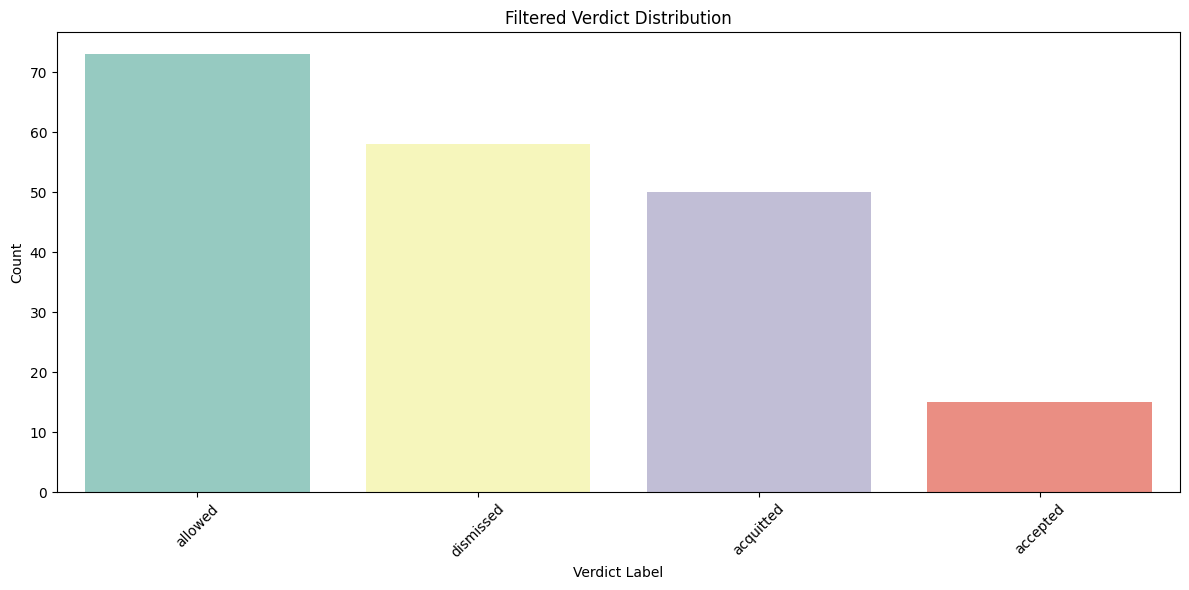

In [5]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="label_name", palette="Set3", order=df["label_name"].value_counts().index)
plt.title("Filtered Verdict Distribution")
plt.xlabel("Verdict Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##Train/Test Split & Dataset Formatting

In [6]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
train_df["text"] = train_df.apply(format_case, axis=1)
val_df["text"] = val_df.apply(format_case, axis=1)

train_ds = Dataset.from_pandas(train_df[["text", "label"]])
val_ds = Dataset.from_pandas(val_df[["text", "label"]])

##Tokenization

In [7]:
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=512)

tokenized_train_ds = train_ds.map(tokenize, batched=True)
tokenized_val_ds = val_ds.map(tokenize, batched=True)

#Remove unnecessary columns
cols_to_remove = [col for col in tokenized_train_ds.column_names if col.startswith("__")]
tokenized_train_ds = tokenized_train_ds.remove_columns(cols_to_remove)
tokenized_val_ds = tokenized_val_ds.remove_columns(cols_to_remove)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/156 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

##Load Model

In [8]:
num_labels = df["label"].max() + 1
model = AutoModelForSequenceClassification.from_pretrained(
    "nlpaueb/legal-bert-base-uncased",
    num_labels=num_labels
)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##Training Setup & Metrics

In [12]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=30,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


##Train Model

In [13]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.124500,0.851806,0.750000,0.738457,0.750000,0.720998
2,0.879200,0.662778,0.725000,0.670215,0.725000,0.693286
3,0.758500,0.626564,0.725000,0.761648,0.725000,0.676557
4,0.486200,0.377627,0.850000,0.856667,0.850000,0.846364
5,0.217400,0.261086,0.925000,0.940000,0.925000,0.926723
6,0.097000,0.421213,0.900000,0.910714,0.900000,0.900688
7,0.042800,0.234761,0.925000,0.925852,0.925000,0.924579
8,0.011800,0.182662,0.950000,0.950000,0.950000,0.950000
9,0.006200,0.204806,0.950000,0.950000,0.950000,0.950000
10,0.004000,0.165377,0.950000,0.950000,0.950000,0.950000


TrainOutput(global_step=600, training_loss=0.121976674447457, metrics={'train_runtime': 784.9196, 'train_samples_per_second': 5.962, 'train_steps_per_second': 0.764, 'total_flos': 1231415018496000.0, 'train_loss': 0.121976674447457, 'epoch': 30.0})

##Evaluation & Plotting

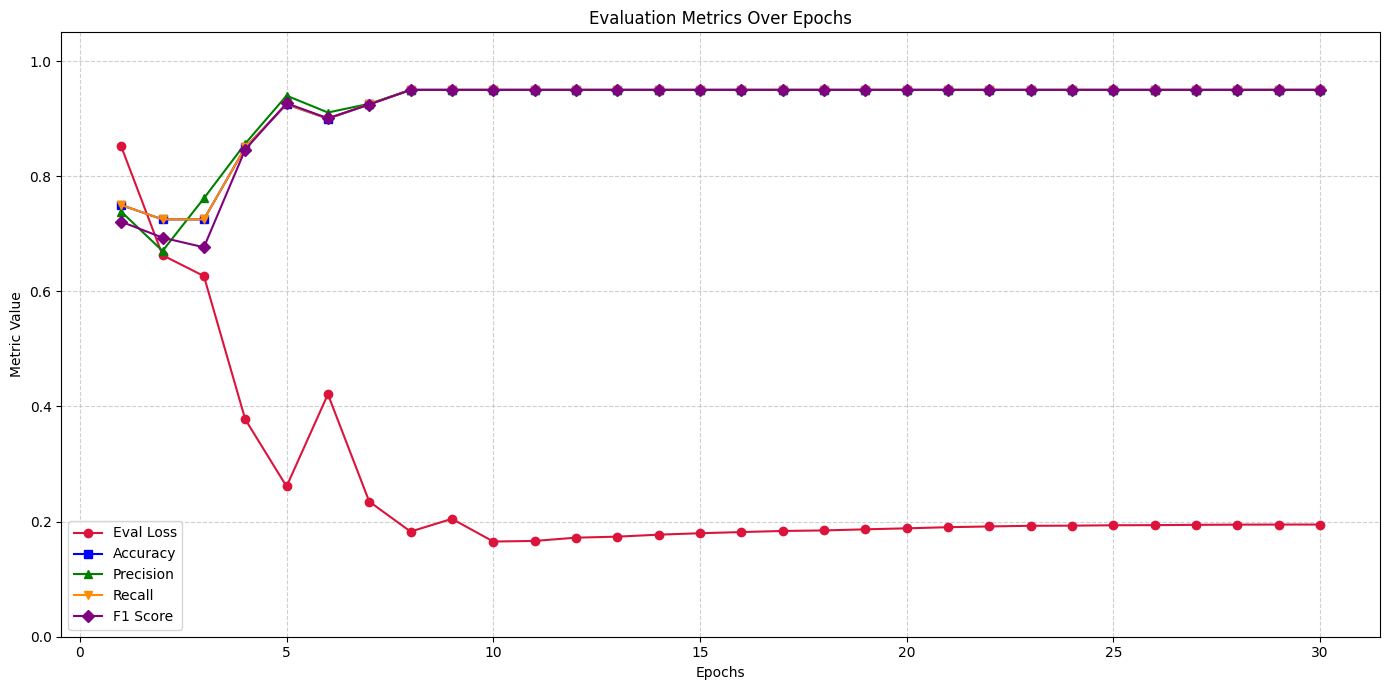

In [14]:
#Auto-detect latest checkpoint
checkpoint_dirs = [ckpt for ckpt in os.listdir("./results") if ckpt.startswith("checkpoint")]
latest_ckpt = sorted(checkpoint_dirs, key=lambda x: int(x.split("-")[-1]))[-1]
trainer_state_path = f"./results/{latest_ckpt}/trainer_state.json"

with open(trainer_state_path, "r") as f:
    logs = json.load(f)

log_history = logs["log_history"]
epochs, eval_loss, eval_accuracy, eval_precision, eval_recall, eval_f1 = [], [], [], [], [], []

for entry in log_history:
    if "eval_loss" in entry:
        epochs.append(entry["epoch"])
        eval_loss.append(entry.get("eval_loss"))
        eval_accuracy.append(entry.get("eval_accuracy"))
        eval_precision.append(entry.get("eval_precision"))
        eval_recall.append(entry.get("eval_recall"))
        eval_f1.append(entry.get("eval_f1"))

#Plot
plt.figure(figsize=(14, 7))
plt.plot(epochs, eval_loss, label="Eval Loss", marker='o', color='crimson')
plt.plot(epochs, eval_accuracy, label="Accuracy", marker='s', color='blue')
plt.plot(epochs, eval_precision, label="Precision", marker='^', color='green')
plt.plot(epochs, eval_recall, label="Recall", marker='v', color='darkorange')
plt.plot(epochs, eval_f1, label="F1 Score", marker='D', color='purple')
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.title("Evaluation Metrics Over Epochs")
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

##Save Model

In [15]:
trainer.save_model("./best_model")
tokenizer.save_pretrained("./best_model")

('./best_model/tokenizer_config.json',
 './best_model/special_tokens_map.json',
 './best_model/vocab.txt',
 './best_model/added_tokens.json',
 './best_model/tokenizer.json')

##Inference / Prediction Function

In [18]:
#Load best saved model and tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

#Load from saved directory
model_path = "./best_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

#Move model to correct device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

#Prediction Function
def predict_verdict(case, model, tokenizer, label_mapping):
    formatted_text = format_case(case)

    #Prepare inputs and move to device
    inputs = tokenizer(
        formatted_text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        predicted_label = torch.argmax(outputs.logits, dim=1).item()

    return label_mapping[predicted_label]

#Example Test Case
sample_case = {
    "summary": "The appellant was convicted under Section 302 for murder but argued that the evidence was circumstantial.",
    "petitioner_argument": "The petitioner argued there was no direct witness and the case relied on weak circumstantial evidence.",
    "respondent_argument": "The prosecution maintained that the motive and weapon recovery strongly supported conviction.",
    "case_type": "Criminal Appeal",
    "offence_sections": ["302", "34"]
}

#Predict verdict
predicted_verdict = predict_verdict(sample_case, model, tokenizer, label_mapping)
print("Predicted Verdict:", predicted_verdict)


Predicted Verdict: acquitted


##Download Model

In [19]:
!zip -r best_model.zip best_model

from google.colab import files
files.download("best_model.zip")


  adding: best_model/ (stored 0%)
  adding: best_model/tokenizer.json (deflated 71%)
  adding: best_model/config.json (deflated 56%)
  adding: best_model/vocab.txt (deflated 51%)
  adding: best_model/model.safetensors (deflated 7%)
  adding: best_model/tokenizer_config.json (deflated 75%)
  adding: best_model/special_tokens_map.json (deflated 42%)
  adding: best_model/training_args.bin (deflated 53%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>